# Project 2

## Authors: Declan Sheehan, Jack Stoetzel

### Description: In this project, we will create two machine learning algorithms and apply it toward one of the datasets in project 1.

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import operator
from numpy import *

# Import data from csv file. CSV file: 10 Columns x 35157 Rows.
COVID = pd.read_csv('data/full_grouped.csv', skiprows=[0], header = None, skipinitialspace = True,
                names = ['date', 'count-reg', 'case', 'death', 'recover', 'active', 'ncase', 'ndeath', 'nrecover', 'who'])


The country's Covid-19 status is: Good


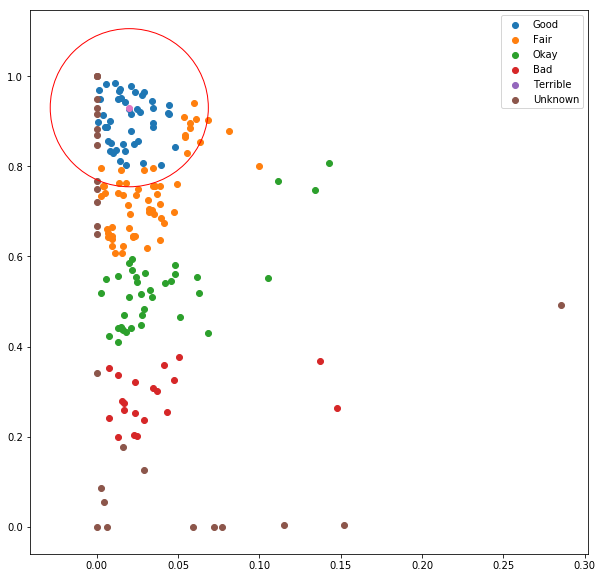

In [7]:
# Altered class from Lab 06 to calculate the k-Nearest-Neighbor.
class kNN:
    def __init__(self, train_data, full_data, labels, k):
        super().__init__()
        self.k = k
        self.labels = labels
        self.distance = None
        self.train(train_data, full_data)
        
    def train(self, train_data, full_data):
        self.full_data = full_data
        self.train_data = train_data
        self.train_size = train_data.shape[0]
        
    def distances(self, sample):
        diffMatrix = tile(sample, (self.train_size, 1)) - self.train_data
        self.distance = ((diffMatrix ** 2).sum(axis = 1) ** 0.5)

    def predict(self, sample):
        self.distances(sample)
        sortedIndices = self.distance.argsort()
        
        label_count = []
        for i in range(len(self.labels)):
            label_count.append(0)
        
        Class = ''
        for num in range(self.k):
            votedPoints = sortedIndices[num]
            for label in self.labels:
                if self.full_data[votedPoints][2] == label:
                    label_count[self.labels.index(label)] += 1
                
        values = array(label_count).argsort()
        Class = self.labels[values[len(self.labels)-1]]
        
        return Class
    
    def print_plot(self, sample):
        plots = []
        ax = ''
        for i in range(len(self.labels)):
            plots.append(([], []))
        
        for num in range(self.train_size):
            plots[self.labels.index(self.full_data[num][2])][0].append(self.train_data[num][0])
            plots[self.labels.index(self.full_data[num][2])][1].append(self.train_data[num][1])
                
        plt.figure(figsize=(10, 10))
        for sett in plots:
            ax = plt.scatter(sett[0], sett[1])
            
        plt.scatter(sample[0], sample[1])
        plt.scatter(sample[0], sample[1], s=25000, facecolors='none', edgecolors='r')
        plt.legend(self.labels)
        plt.show()

################################################################

# Calculate 'death rates' and 'recovery rates' for each country to classify them.
Recovery = COVID[['count-reg', 'case', 'death', 'recover']].groupby(['count-reg']).max().sort_values(['count-reg'], ascending=True)
Recovery['recoverratio'] = Recovery['recover'] / Recovery['case']
Recovery['deathratio'] = Recovery['death'] / Recovery['case']
Recovery = pd.DataFrame(dict(dr=Recovery['deathratio'], rr=Recovery['recoverratio'], country=Recovery.index))

# Set up the data by giving them labels based on above rates.
full_data = []
train_data = []
for num in range(len(Recovery)):
    full_data.append([Recovery['dr'][num], Recovery['rr'][num]])
    train_data.append([Recovery['dr'][num], Recovery['rr'][num]])
    
# Assigning covid-19 status.
for point in full_data:
    if point[0] == 0.00 or point[1] == 0.00:
        point.append('Unknown')
    elif point[0] <= 0.05 and point[1] >= 0.80:
        point.append('Good')
    elif point[0] <= 0.10 and point[1] >= 0.60:
        point.append('Fair')
    elif point[0] <= 0.15 and point[1] >= 0.40:
        point.append('Okay')
    elif point[0] <= 0.20 and point[1] >= 0.20:
        point.append('Bad')
    elif point[0] >= 0.20 and point[1] <= 0.20:
        point.append('Terrible')
    else:
        point.append('Unknown')
        
# Run the model and make predictions.
test_data = [[0.03, 0.72], [0.02, 0.93], [0.08, 0.25]]
model = kNN(array(train_data), array(full_data), ['Good', 'Fair', 'Okay', 'Bad', 'Terrible', 'Unknown'], 5)
print('The country\'s Covid-19 status is:', model.predict(array(test_data[1])))
model.print_plot(array(test_data[1]))
